In [2]:
!pip install brian2 networkx matplotlib ipywidgets



In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from brian2 import *
import ipywidgets as widgets
from IPython.display import display


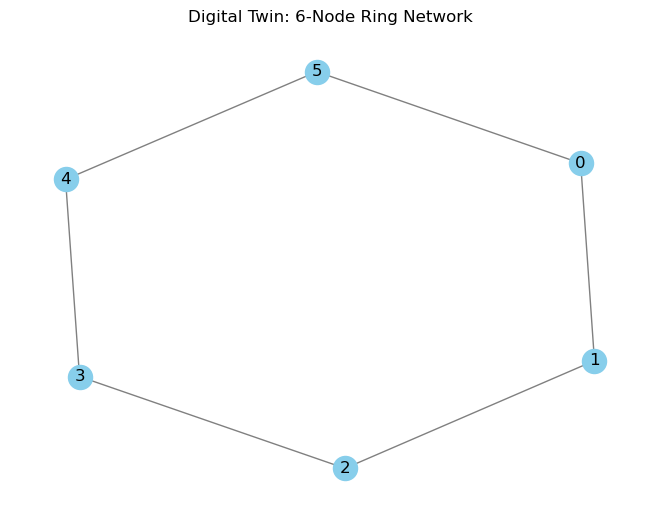

In [4]:
G = nx.cycle_graph(6)
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray')
plt.title("Digital Twin: 6-Node Ring Network")
plt.show()
n_nodes = len(G.nodes)


In [5]:
duration = 400*ms
traffic_sources = PoissonGroup(n_nodes, rates='60*Hz')
mon_input = SpikeMonitor(traffic_sources)


In [6]:
eqs = '''
dv/dt = (1.0 - v)/tau : 1
tau : second
'''

agents = NeuronGroup(n_nodes, eqs, threshold='v>1', reset='v = 0', method='exact')
agents.tau = '12*ms'

# STDP Synapse Model
syn_model = '''
w : 1
dApre/dt = -Apre / tau_pre : 1 (event-driven)
dApost/dt = -Apost / tau_post : 1 (event-driven)
'''

on_pre = '''
v_post += w
Apre += dApre
w = clip(w + Apost, 0, wmax)
'''

on_post = '''
Apost += dApost
w = clip(w + Apre, 0, wmax)
'''

tau_pre = 20*ms
tau_post = 20*ms
dApre = 0.01
dApost = -0.012
wmax = 1.0

syn = Synapses(traffic_sources, agents, model=syn_model,
               on_pre=on_pre, on_post=on_post)
syn.connect(j='i')
syn.w = '0.3 + 0.2*rand()'

mon_output = SpikeMonitor(agents)


In [7]:
def compute_firing_rates(spike_monitor, sim_time=400):
    counts = np.array([spike_monitor.count[i] for i in range(n_nodes)])
    return counts / sim_time

def make_routing_decision(firing_rates):
    sorted_nodes = np.argsort(-firing_rates)
    route = sorted_nodes[:3]
    return route


WARNING    'tau_post' is an internal variable of group 'synapses', but also exists in the run namespace with the value 20. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Firing Rates per Node: [0.035  0.04   0.0425 0.0425 0.0275 0.0525]
Routing Path (Top 3 Active Nodes): [5 2 3]


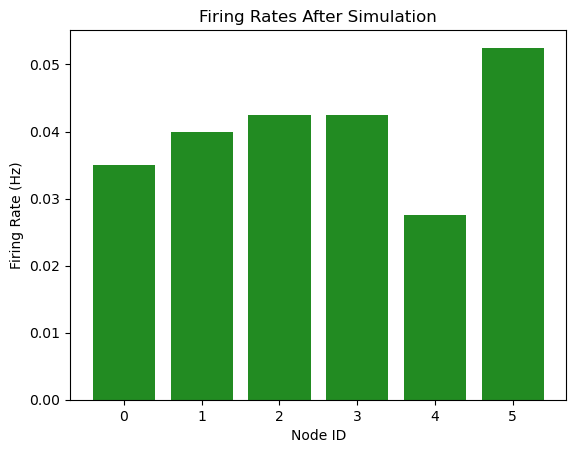

In [8]:
run(duration)

firing_rates = compute_firing_rates(mon_output, sim_time=duration/ms)
routing_path = make_routing_decision(firing_rates)

print("Firing Rates per Node:", firing_rates)
print("Routing Path (Top 3 Active Nodes):", routing_path)

plt.bar(range(n_nodes), firing_rates, color='forestgreen')
plt.title("Firing Rates After Simulation")
plt.xlabel("Node ID")
plt.ylabel("Firing Rate (Hz)")
plt.show()


In [9]:
def simulate_link_failure(graph, fail_node):
    new_graph = graph.copy()
    if new_graph.has_node(fail_node):
        new_graph.remove_node(fail_node)
    plt.figure()
    nx.draw(new_graph, pos, with_labels=True, node_color='salmon')
    plt.title(f"Simulated Failure: Node {fail_node} Down")
    plt.show()


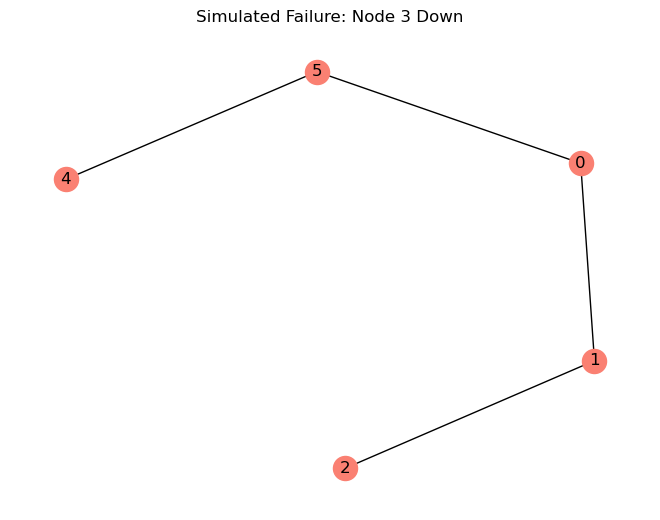

In [10]:
simulate_link_failure(G, 3)  # Try Node 3 failure


In [ ]:
fail_slider = widgets.IntSlider(min=0, max=n_nodes-1, step=1, description='Fail Node:')
display(fail_slider)

def dashboard_view(f_node):
    G_new = G.copy()
    if G_new.has_node(f_node):
        G_new.remove_node(f_node)
    plt.figure()
    nx.draw(G_new, pos, with_labels=True, node_color='orange')
    plt.title(f"Live Network View: Node {f_node} Down")
    plt.show()

widgets.interact(dashboard_view, f_node=fail_slider);


IntSlider(value=0, description='Fail Node:', max=5)

interactive(children=(IntSlider(value=0, description='Fail Node:', max=5), Output()), _dom_classes=('widget-in…